# Individual Part - Coverage

In this part, i will perform the lexicon's coverage of a target's vocabulary.

In [1]:
from pyspark.sql import SparkSession
from bs4 import BeautifulSoup
from pyspark.sql.functions import udf, when, lower, col, count
from pyspark.sql.types import StructType, StructField, StringType
from data_class.Jesmine_Coverage import CoverageFunction
import matplotlib.pyplot as plt
import requests

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Lexicon Coverage Analysis") \
    .getOrCreate()

24/12/21 18:18:01 WARN Utils: Your hostname, MSI. resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/21 18:18:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/21 18:18:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/21 18:18:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/21 18:18:02 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


# Web Scraping for Article

In [2]:
url = "https://www.ipendidikan.my/cara-mengamalkan-gaya-hidup-sihat.html"

articles = CoverageFunction.scrapingWebPage(url)
words = CoverageFunction.scrapingWord(url)

if words:
    print(f"Successfully retrieved {len(words)} words:")
    print(words[:10]) 
else:
    print("No words retrieved.")

Successfully retrieved 1298 words:
['Cara', 'Mengamalkan', 'Gaya', 'Hidup', 'Sihat', 'Contoh', 'Karangan', 'Menu', 'Result', 'BPKP']


In [3]:
#Wrap each of the word to match the schema
words_wrapped = [(word,) for word in words]

#Define the schema of the dataframes
schema = StructType([
    StructField("Kata", StringType(), True)
])

#Create the DataFrame
df = spark.createDataFrame(words_wrapped, schema=schema)

df.show(10)

+-----------+
|       Kata|
+-----------+
|       Cara|
|Mengamalkan|
|       Gaya|
|      Hidup|
|      Sihat|
|     Contoh|
|   Karangan|
|       Menu|
|     Result|
|       BPKP|
+-----------+
only showing top 10 rows



In [4]:
#Convert into lowercase 
df = df.withColumn("Kata", lower(df["Kata"]))
df.show(10)

+-----------+
|       Kata|
+-----------+
|       cara|
|mengamalkan|
|       gaya|
|      hidup|
|      sihat|
|     contoh|
|   karangan|
|       menu|
|     result|
|       bpkp|
+-----------+
only showing top 10 rows



# Load the Lexicon and compare the words in lexicon to determine the coverage

In [5]:
#Load the lexicon CSV file
lexicon_df = spark.read.csv(
    "lexicon.csv", 
    header=True,         
    inferSchema=True,   
    multiLine=True,     
    sep=",",
    quote='"',          
    escape='"'           
)

#Extract the lexicon words into a list
lexicon = [row["Kata"] for row in lexicon_df.select("Kata").collect()]

#Check if the word is in the lexicon
coverage_df = df.withColumn(
    "Coverage_in_Lexicon", col("Kata").isin(lexicon)
)

#Group by word to calculate frequency and lexicon status
word_freq_df = coverage_df.groupBy("Kata", "Coverage_in_Lexicon").agg(
    count("Kata").alias("Frequency")
)

word_freq_data = word_freq_df.collect()
word_freq_df.show()

+---------+-------------------+---------+
|     Kata|Coverage_in_Lexicon|Frequency|
+---------+-------------------+---------+
| facebook|              false|        2|
|  jantung|               true|        3|
| daripada|              false|       12|
| telegram|              false|        2|
|    hidup|               true|       19|
|     bpkp|              false|        1|
|    tahun|               true|        1|
|    share|              false|        2|
| tertanya|              false|        1|
|    dalam|               true|       13|
|   rakyat|               true|        2|
|pinterest|              false|        2|
|  masalah|               true|        7|
|     menu|              false|        1|
|      kes|              false|        2|
|   berita|               true|        1|
|  seperti|              false|       10|
| linkedin|              false|        2|
|     yang|               true|       47|
|    untuk|               true|       17|
+---------+-------------------+---

In [6]:
#Create a table for words that exists in lexicon
true_df = word_freq_df.filter(col("Coverage_in_Lexicon") == "true").orderBy(col("Frequency").desc())
true_df.show()

+---------+-------------------+---------+
|     Kata|Coverage_in_Lexicon|Frequency|
+---------+-------------------+---------+
|     yang|               true|       47|
|      dan|               true|       31|
|     kita|               true|       21|
|     diri|               true|       20|
|    hidup|               true|       19|
|kesihatan|               true|       17|
|    untuk|               true|       17|
|     cara|               true|       17|
|      ini|               true|       17|
|     gaya|               true|       15|
| aktiviti|               true|       15|
|     atau|               true|       14|
|  makanan|               true|       14|
|   dengan|               true|       13|
|    dalam|               true|       13|
|   kepada|               true|       11|
|    serta|               true|       11|
|  tekanan|               true|       11|
|   adalah|               true|       11|
|   contoh|               true|        9|
+---------+-------------------+---

In [7]:
#Create a table for words that does not exist in lexicon
false_df = word_freq_df.filter(col("Coverage_in_Lexicon") == "false").orderBy(col("Frequency").desc())
false_df.show()

+------------+-------------------+---------+
|        Kata|Coverage_in_Lexicon|Frequency|
+------------+-------------------+---------+
|       sihat|              false|       25|
| mengamalkan|              false|       13|
|    daripada|              false|       12|
|       boleh|              false|       11|
|        juga|              false|       11|
|     seperti|              false|       10|
|        oleh|              false|        7|
|     menjaga|              false|        7|
|    malaysia|              false|        6|
|    tersebut|              false|        6|
|   melakukan|              false|        6|
| menjejaskan|              false|        6|
|     sebagai|              false|        5|
| pemeriksaan|              false|        5|
|      secara|              false|        5|
|persekitaran|              false|        4|
|     perkara|              false|        4|
| berdasarkan|              false|        4|
| membolehkan|              false|        4|
|   seseor

# Display the Article

In [8]:
#Separate words into two groups
covered_words = [row["Kata"] for row in word_freq_data if row["Coverage_in_Lexicon"]]
uncovered_words = [row["Kata"] for row in word_freq_data if not row["Coverage_in_Lexicon"]]
uncovered_freq = [row["Frequency"] for row in word_freq_data if not row["Coverage_in_Lexicon"]]

highlighted_full_text = CoverageFunction.highlight_text(articles, covered_words, uncovered_words)

print("Highlighted Article:")
print(highlighted_full_text)

Highlighted Article:
Cara Mengamalkan Gaya Hidup Sihat (Contoh Karangan) Menu Result BPKP Contoh Karangan Karangan Cara Mengamalkan Gaya Hidup Sihat Share Facebook Twitter LinkedIn Pinterest WhatsApp Telegram contoh karangan mengamalkan gaya hidup sihat Ipendidikan » Karangan » Cara Mengamalkan Gaya Hidup Sihat Dalam era modenisasi ini, pastinya ramai tertanya-tanya apakah cara mengamalkan gaya hidup sihat. Hal ini kerana, kita sering dikejutkan dengan berita yang tidak berapa sedap untuk didengari berkenaan masalah kesihatan rakyat Malaysia . Sebagai contoh, meningkatnya kes-kes penyakit kritikal seperti sakit jantung, kanser, diabetes dan lain-lain penyakit yang berkaitan. Malaysia kini dikatakan mempunyai masalah obesiti yang serius. Empat daripada sepuluh orang dewasa yang melebihi usia 18 tahun di negara ini sama ada mengalami berat badan berlebihan (obesiti) atau lebih dikenali sebagai kegemukan. Oleh itu, kita mestilah mengetahui cara-cara menjalani kehidupan yang sihat agar dir

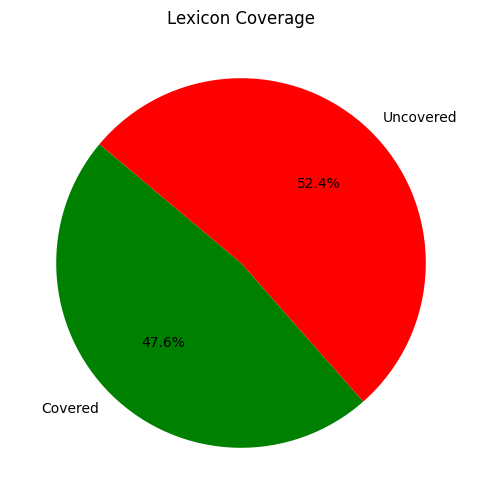

In [9]:
#Pie Chart for Visualization
coverage_counts = [len(covered_words), len(uncovered_words)]
labels = ["Covered", "Uncovered"]
colors = ["green", "red"]

plt.figure(figsize=(6, 6))
plt.pie(
    coverage_counts, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140
)
plt.title("Lexicon Coverage")
plt.show()

In [10]:
#Stop Spark session
spark.stop()